## TP N 2 : k-plus proches voisins, analyse discriminante linéaire et régression logistique

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import Counter
from sklearn import metrics
from scipy.spatial import distance

from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
from tpknnsource import (rand_gauss, rand_bi_gauss, rand_tri_gauss, rand_checkers,
                                  rand_clown, plot_2d, frontiere_new, ErrorCurve, frontiere, LOOCurve)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import neighbors, datasets
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

### Data Generation: Génération artificielle de données

From rand_bi_gauss

In [2]:
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

From rand_tri_gauss

In [3]:
n1=50
n2=50
n3=50
mu1 = [1.,1.]
mu2 = [-1.,-1.]
mu3 = [1.,-1.]
sigma1 = [0.9,0.9]
sigma2 = [0.9,0.9]
sigma3 = [0.9,0.9]
X2, y2 =rand_tri_gauss(n1, n2, n3, mu1,mu2, mu3, sigma1,sigma2, sigma3)

From rand_clown

In [4]:
n1=100
n2=100
sigma1=1
sigma2=2

X3, y3 =rand_clown(n1, n2, sigma1, sigma2)

From rand_checkers

In [5]:
n1=150
n2=150
sigma=0.9

X4,y4=rand_checkers(n1=100, n2=100, sigma=0.9)

##### Que renvoient ces fonctions ? À quoi correspond la dernière colonne ?

### Displaying labeled data

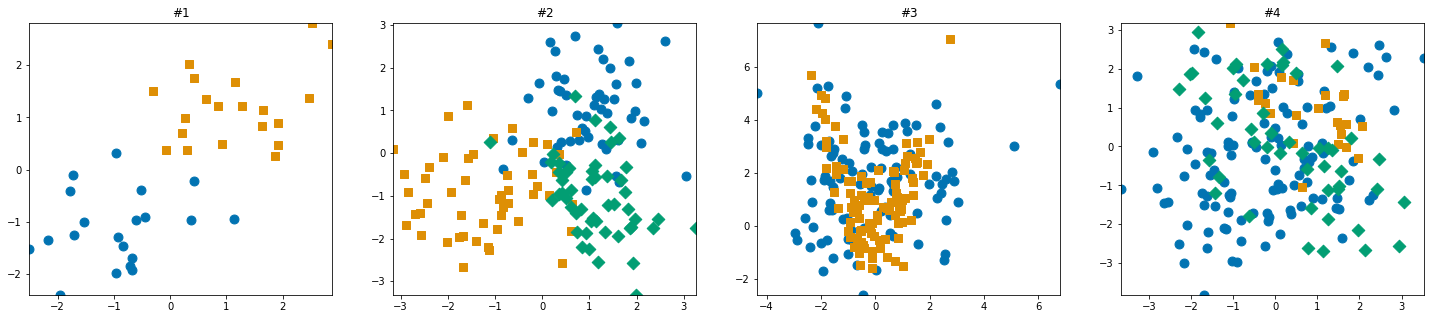

In [6]:
plt.close("all")
plt.figure(1, figsize=(25, 5))
plt.subplot(141)
plt.title('#1')
plot_2d(X1, y1)
plt.subplot(142)
plt.title('#2')
plot_2d(X2, y2)
plt.subplot(143)
plt.title('#3')
plot_2d(X3, y3)
plt.subplot(144)
plt.title('#4')
plot_2d(X4, y4)
plt.show()

### Approche intuitive
3) Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y sont à valeurs réelles : Y = R

Il s'agit de classer l'entrée dans la catégorie à laquelle appartiennent les k plus proches voisins dans l'espace des caractéristiques identifiées par apprentissage. Cette valeur est la moyenne des valeurs des k plus proches voisins pour une régression. On peut donner à chaque voisin une pondération en fonction de la distance de l'élément à classer de ce voisin.
- Etape 1: On récupère le nombre de voisins
- Etape 2: On calcule la distance entre l'échantillon et les valeurs observées
- Etape 3: On prédit les valeurs 

### Approche formelle

In [7]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1):
        self.n=n_neighbors   # n_neighbors represents number of neighbors we will select 
        print("Number of neighbors : \n", self.n)
        return
    
    
    def fit(self, X, y):
        self.y_train=y
        self.X_train=X
        return self
    
    def predict(self, X):
        print("X.shape ", X.shape)
        n_samples, n_features = X.shape
        print("X.n_samples ", n_samples)
        print("X.n_features ", n_features)


        dist = distance.cdist(X, self.X_train, "euclidean")
        print("\n Distance between X_test and X_train \n", dist)

        idx_sort = np.argsort(dist, axis=1)
        print("\n Sorted by index \n", idx_sort)

        idx_neighbors = idx_sort[:, :self.n]
        print("We take only n_neighbors indexes \n", idx_neighbors)


        Y_neighbors = self.y_train[idx_neighbors]
        print("Y_neighbors  :",  Y_neighbors)
        
        y_pred = np.array([])
        
        for i in range(n_samples):
            #identify the most commun class
            cnt = Counter(Y_neighbors[i,:]).most_common()
            y_pred = np.append(y_pred, [cnt[0][0]])

        return y_pred
    

On sépare entre les indices pairs et impairs.

In [8]:
X_train = X2[::2]
Y_train = y2[::2].astype(int)
X_test = X2[1::2]
Y_test = y2[1::2].astype(int)

X2_even_train = X2[0::2] # pair
y2_even_train = y2[0::2]
X2_odd_test = X2[1::2] # impair
y2_odd_test = y2[1::2]

### Results with KNNClassifier from scratch using #2

In [9]:
clf = KNNClassifier(n_neighbors=4)
clf.fit(X2_even_train, y2_even_train)
KNN_scratch=clf.predict(X2_odd_test)
KNN_scratch

Number of neighbors : 
 4
X.shape  (75, 2)
X.n_samples  75
X.n_features  2

 Distance between X_test and X_train 
 [[0.16812939 1.72625282 1.62736708 ... 0.61617284 0.94565299 1.47724222]
 [1.93925641 3.21979437 3.47643053 ... 2.59389557 2.5514508  2.91113609]
 [2.1117662  0.95868954 2.35260568 ... 1.98041777 2.4863869  1.16433905]
 ...
 [3.39929908 1.83137055 4.55615517 ... 3.79758147 4.29088161 1.9780842 ]
 [1.82233935 0.27425463 2.93420179 ... 2.1533258  2.65170145 0.33639623]
 [3.98899965 3.45936917 2.88676161 ... 3.40213679 3.67444494 3.6315789 ]]

 Sorted by index 
 [[24  0 51 ... 65 43 27]
 [50 52  8 ... 65 43 27]
 [40  1 48 ... 19 63 27]
 ...
 [46 18 15 ... 58 63 27]
 [23  1 74 ... 58 43 27]
 [43 64 12 ... 50 18 52]]
We take only n_neighbors indexes 
 [[24  0 51 30]
 [50 52  8  0]
 [40  1 48 34]
 [ 8 50  0 24]
 [21  9 61 51]
 [26 73 59 57]
 [71  8 20 39]
 [10 42 38 57]
 [15 18 41 67]
 [40 34 61 66]
 [20 71 35 17]
 [21 37 59 72]
 [16 37 54  5]
 [50  8 52 71]
 [22 59 56  2]
 [20 

array([3., 2., 1., 2., 3., 3., 2., 3., 2., 1., 2., 1., 3., 2., 3., 2., 1.,
       1., 2., 1., 1., 2., 3., 2., 1., 1., 2., 2., 3., 2., 1., 2., 3., 3.,
       3., 1., 2., 2., 1., 2., 3., 1., 2., 1., 1., 1., 1., 1., 1., 2., 3.,
       3., 3., 1., 1., 2., 3., 3., 2., 1., 2., 2., 3., 2., 3., 2., 1., 2.,
       1., 2., 1., 3., 2., 2., 1.])

## La stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans Vk(x).

### Results with KNeighborsClassifier using #2

In [10]:
clf_sklearn = neighbors.KNeighborsClassifier(3)
clf_sklearn.fit(X2_even_train, y2_even_train)
KNeighborsClassifier = clf_sklearn.predict(X2_odd_test)
KNeighborsClassifier

array([3., 2., 1., 2., 3., 3., 2., 3., 2., 1., 2., 1., 3., 2., 3., 2., 1.,
       1., 2., 1., 1., 2., 3., 2., 1., 1., 2., 2., 3., 2., 1., 2., 3., 3.,
       3., 3., 2., 2., 1., 2., 3., 1., 2., 1., 1., 2., 1., 1., 1., 2., 3.,
       3., 3., 3., 1., 2., 3., 3., 2., 1., 2., 2., 1., 2., 3., 2., 1., 2.,
       1., 2., 1., 3., 2., 2., 1.])

### Comparison between KNeighborsClassifier using #2 and KNN from scratch

In [11]:
KNN_scratch==KNeighborsClassifier

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [12]:
# K=5
clf_sklearn = neighbors.KNeighborsClassifier(5)

#Function for frontiere_new 
def f(x):
    return clf_sklearn.predict(x.reshape(1, -1))

##### First dataset #1

In [13]:
X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

clf_sklearn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

##### Second dataset #2

In [14]:
X_train2 = X2[::2]
Y_train2 = y2[::2].astype(int)
X_test2 = X2[1::2]
Y_test2 = y2[1::2].astype(int)

clf_sklearn.fit(X_train2, Y_train2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

##### Third dataset #3

In [15]:
X_train3 = X3[::2]
Y_train3 = y3[::2].astype(int)
X_test3 = X3[1::2]
Y_test3 = y3[1::2].astype(int)

clf_sklearn.fit(X_train3, Y_train3)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

##### Fourth dataset #4

In [16]:
X_train4 = X4[::2]
Y_train4 = y4[::2].astype(int)
X_test4 = X4[1::2]
Y_test4 = y4[1::2].astype(int)

clf_sklearn.fit(X_train4, Y_train4)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Displaying datasets

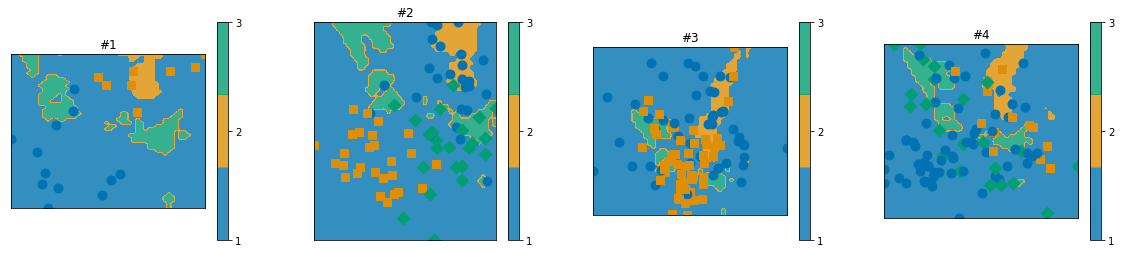

In [17]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

plt.close("all")
plt.figure(figsize=(20, 4))

plt.subplot(141)
plt.title('#1')
frontiere_new(f, X_test, Y_test)

plt.subplot(142)
plt.title('#2')
frontiere_new(f, X_test2, Y_test2)
plt.subplot(143)
plt.title('#3')
frontiere_new(f, X_test3, Y_test3)
plt.subplot(144)
plt.title('#4')
frontiere_new(f, X_test4, Y_test4)
plt.show()

### Variation of n_neighbors from 1 to 30

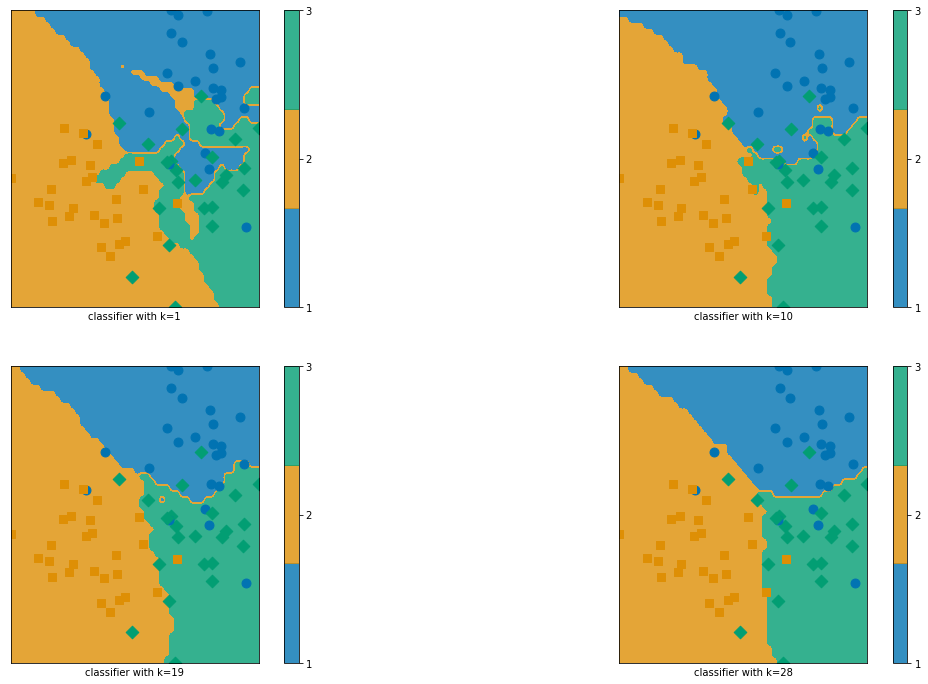

In [18]:
i=0

plt.figure(figsize=(20,12))

for n_neighbors in range(1, 30, 9):
    i=i+1
    cln = neighbors.KNeighborsClassifier(n_neighbors)
    cln.fit(X_train2, Y_train2)
    plt.subplot(2,2,i)
    plt.xlabel('classifier with k=%d' % n_neighbors)
    #print(n_neighbors)
    def f(x):
        return cln.predict(x.reshape(1, -1))
    frontiere_new(f, X_test2, Y_test2)
plt.show()
    

### Extreme cases (for k=1 and k=n=75)

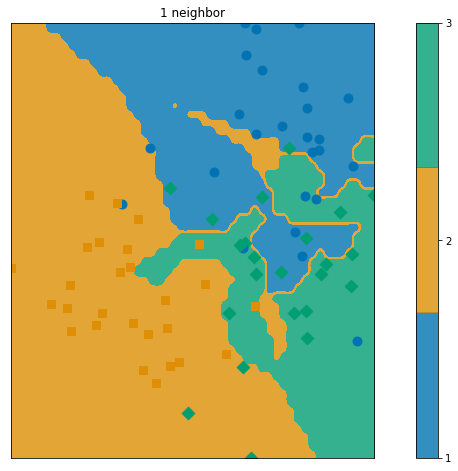

In [19]:
plt.figure(figsize=(15,8))
knn=neighbors.KNeighborsClassifier(1)
knn.fit(X_train2,Y_train2)
def f(x):
        return knn.predict(x.reshape(1, -1))
plt.title('1 neighbor')
frontiere_new(f, X_test2, Y_test2)

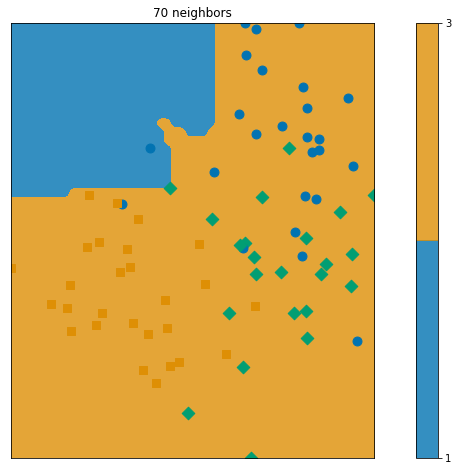

In [20]:
plt.figure(figsize=(15,8))
knn=neighbors.KNeighborsClassifier(70)
knn.fit(X_train2,Y_train2)
def f(x):
        return knn.predict(x.reshape(1,-1))
plt.title('70 neighbors')
frontiere_new(f, X_test2, Y_test2)

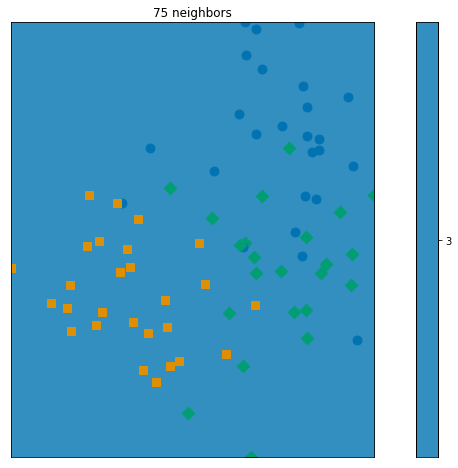

In [21]:
plt.figure(figsize=(15,8))
knn=neighbors.KNeighborsClassifier(75)
knn.fit(X_train2,Y_train2)
def f(x):
        return knn.predict(x.reshape(1, -1))
plt.title('75 neighbors')
frontiere_new(f, X_test2, Y_test2)

### Weighted KNN neighbors attributes

We want to weight the j-th neighbor : $e^{-d²_j/h}$ and implement the obtained weight to KNeighborsClassifier of scikit-learn.

For  k=7 , $h=10^{-2}$

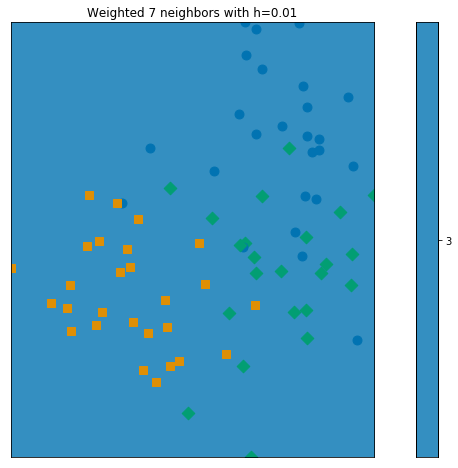

In [22]:
def weights(dist):
    h=0.01
    w = np.exp(-dist**2/h)
    return w

def f(x):
    return knn.predict(x.reshape(1, -1))

n_neighbors=7
plt.figure(figsize=(15,8))
wknn=neighbors.KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights)
knn.fit(X_train2,Y_train2)

plt.title('Weighted 7 neighbors with h=0.01')
frontiere_new(f, X_test2, Y_test2)

For  $k=7$ , $h=10^{-1}$

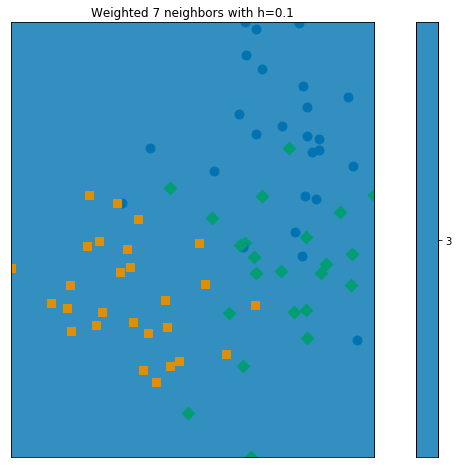

In [23]:
def weights(dist):
    h=0.1
    w = np.exp(-dist**2/h)
    return w

plt.figure(figsize=(15, 8))
wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights)
knn.fit(X_train2,Y_train2)

plt.title('Weighted 7 neighbors with h=0.1')
frontiere_new(f, X_test2, Y_test2)

$For $ $ k=7 , h=1$

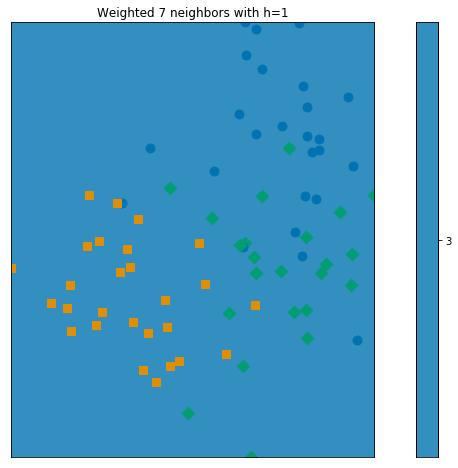

In [24]:
def weights(dist):
    h=1
    w = np.exp(-dist**2/h)
    return w

plt.figure(figsize=(15, 8))
wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights)
knn.fit(X_train2,Y_train2)

plt.title('Weighted 7 neighbors with h=1')
frontiere_new(f, X_test2, Y_test2)

$For $ $ k=7 $ ,  $h=10^{2}$

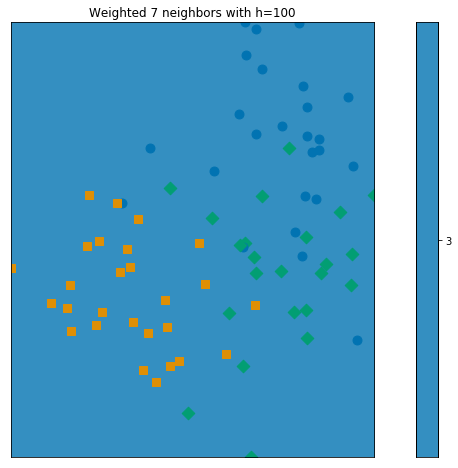

In [25]:
def weights(dist):
    h=100
    w = np.exp(-dist**2/h)
    return w

plt.figure(figsize=(15, 8))
wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights)
knn.fit(X_train2,Y_train2)

plt.title('Weighted 7 neighbors with h=100')
frontiere_new(f, X_test2, Y_test2)

### Error on training set

In [26]:
wknn = neighbors.KNeighborsClassifier(n_neighbors = 1)
wknn.fit(X_train2, Y_train2)
erreur=1-wknn.score(X_train2, Y_train2)
print("Error on training set: " + str(round(erreur,3)))

Error on training set: 0.0


### Error on test set

In [27]:
erreur=1-wknn.score(X_test2, Y_test2)
print("Error on test set: " + str(round(erreur,3)))

Error on test set: 0.2


In [28]:
from sklearn.metrics import accuracy_score
Y_pred = wknn.predict(X_test2)
print(round(accuracy_score(Y_test2, Y_pred),3))

0.8


### Error Curve for k = 1, 2, . . . , 50

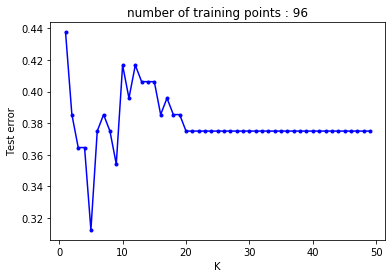

In [29]:
weights='uniform'
X4_error = ErrorCurve(k_range=list(range(1,50)),weights=weights)
ErrorCurve.fit_curve(X4_error,X_train4, Y_train4, X_test4, Y_test4)
#X4_error.fit_curve(X_train4, Y_train4, X_test4, Y_test4)
X4_error.plot(marker='.',color='blue')

### Error curves depending on k = (1, 2, . . . , 50) for set #4

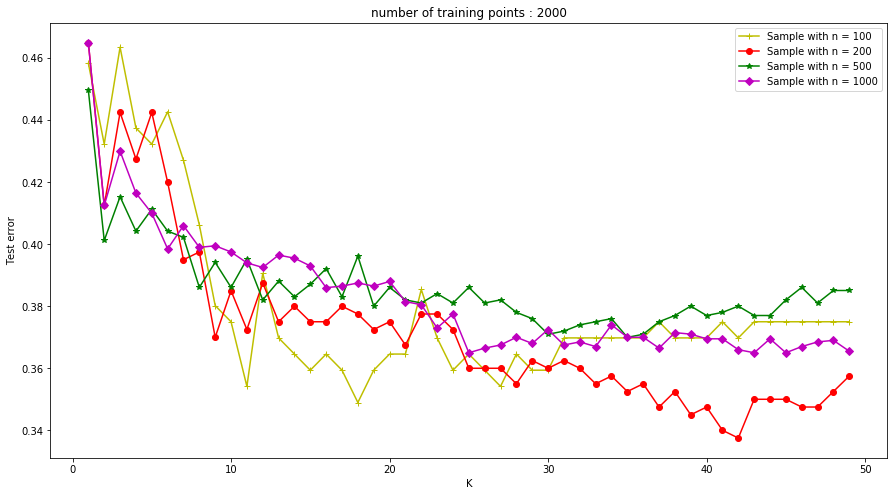

In [30]:
samples=[100,200,500,1000]
m=['+','o','*','D','p']
c=['y','r','g','m','b']

plt.figure(figsize=(15, 8))
for i, sample in enumerate(samples):
    label='Sample with n = ' +str(sample)
    n1 = sample
    n2 = sample
    X_train, Y_train = rand_checkers(n1, n2, sigma)
    X_test, Y_test = rand_checkers(n1, n2, sigma)
    X4_error = ErrorCurve(k_range=list(range(1,50)))
    X4_error.fit_curve(X_train,Y_train, X_test,Y_test)
    
    X4_error.plot(marker=m[i],color=c[i],label=label)
    plt.legend()

#### Displaying for n = 1000

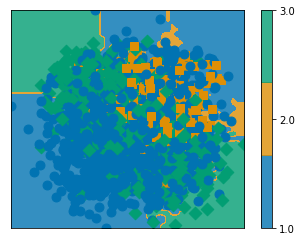

In [31]:
n=1000
n_neighbors = 7
X_tr4, Y_tr4 = rand_checkers(n, n, sigma)
X_te4, Y_te4 = rand_checkers(n, n, sigma)
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_tr4, Y_tr4)
frontiere_new(f, X_te4, Y_te4)

### Pros and Cons of K-Nearest Neighbors

### Digits from scikit-learn

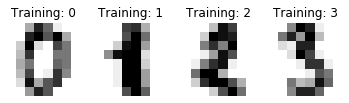

In [32]:
# The digits dataset
digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [33]:
#digits.keys()
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

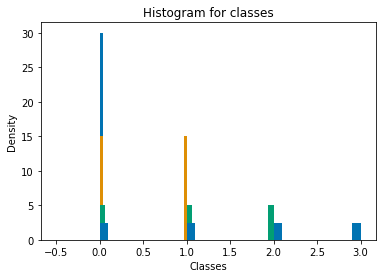

In [34]:
lab=[]
for index, (image, label) in enumerate(images_and_labels[:4]):
    lab.append(label)
    
    plt.hist(lab, bins=30, density=True)
    plt.xlabel("Classes")
    plt.ylabel("Density")
    plt.title("Histogram for classes")

### Splitting the samples in train and test

In [35]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(digits.data, digits.target , test_size=0.5)

In [36]:
n_neighbors=30
clss=neighbors.KNeighborsClassifier(30)
clss.fit(Xtrain, Ytrain)
y_kclss=clss.predict(Xtest)

clss.fit(Xtest,Ytest)
err=1-clss.score(Xtest,Ytest)

print("Error on test set: " + str(round(err,3)))
print("Accuracy score : ",accuracy_score(Ytest, y_kclss))

Error on test set: 0.037
Accuracy score :  0.9477196885428254


### Confusion matrix

Confusion matrix, without normalization
[[ 91   0   0   0   1   0   0   0   0   0]
 [  0  79   5   0   0   0   2   0   0   1]
 [  1   2  90   0   0   0   0   0   2   0]
 [  0   0   0  83   0   0   0   2   3   1]
 [  0   1   0   0  98   0   0   2   0   0]
 [  0   0   0   0   0  78   1   0   0   3]
 [  0   0   0   0   0   0 100   0   0   0]
 [  0   0   0   0   0   0   0  82   0   0]
 [  0   5   1   3   0   1   0   1  73   0]
 [  1   1   0   3   0   0   0   4   0  78]]
Normalized confusion matrix
[[0.99 0.   0.   0.   0.01 0.   0.   0.   0.   0.  ]
 [0.   0.91 0.06 0.   0.   0.   0.02 0.   0.   0.01]
 [0.01 0.02 0.95 0.   0.   0.   0.   0.   0.02 0.  ]
 [0.   0.   0.   0.93 0.   0.   0.   0.02 0.03 0.01]
 [0.   0.01 0.   0.   0.97 0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.   0.   0.95 0.01 0.   0.   0.04]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.06 0.01 0.04 0.   0.01 0.   0.01 0.87 0.  ]
 [0.01 0.01 0.   0.03 0.

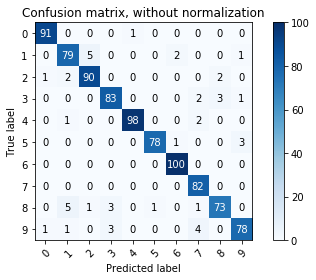

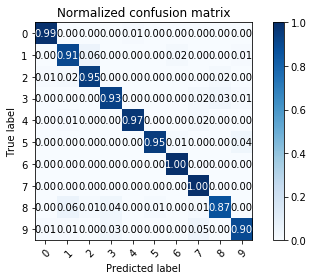

In [37]:
class_names = digits.target_names

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Ytest, y_kclss, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Ytest, y_kclss, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Method to choose k: Cross Validation

When evaluating different hyperparameters and splitting the data into 3 sets, there is a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally.

To avoid this problem and to choose a right hyperparameter k, we can apply a cross validation (CV) by training the model on the training set, which is split into k-folds, and evaluating it on the remaining validation set and finally evaluating it with the test set.

In [38]:
k = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
list(k)

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]

In [39]:
for c in list(k):
    clf = svm.SVC(kernel='linear', C=c)
    scores = cross_val_score(clf, digits.data, digits.target, cv=2) #it is just an example to understand with cv=2
    print('Score for k = ',c, " ", scores)

Score for k =  1   [0.93 0.95]
Score for k =  6   [0.93 0.95]
Score for k =  11   [0.93 0.95]
Score for k =  16   [0.93 0.95]
Score for k =  21   [0.93 0.95]
Score for k =  26   [0.93 0.95]
Score for k =  31   [0.93 0.95]
Score for k =  36   [0.93 0.95]
Score for k =  41   [0.93 0.95]
Score for k =  46   [0.93 0.95]
Score for k =  100   [0.93 0.95]
Score for k =  200   [0.93 0.95]


In [40]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
for train, test in loo.split(k):
    print("%s %s" % (train, test))

[ 1  2  3  4  5  6  7  8  9 10 11] [0]
[ 0  2  3  4  5  6  7  8  9 10 11] [1]
[ 0  1  3  4  5  6  7  8  9 10 11] [2]
[ 0  1  2  4  5  6  7  8  9 10 11] [3]
[ 0  1  2  3  5  6  7  8  9 10 11] [4]
[ 0  1  2  3  4  6  7  8  9 10 11] [5]
[ 0  1  2  3  4  5  7  8  9 10 11] [6]
[ 0  1  2  3  4  5  6  8  9 10 11] [7]
[ 0  1  2  3  4  5  6  7  9 10 11] [8]
[ 0  1  2  3  4  5  6  7  8 10 11] [9]
[ 0  1  2  3  4  5  6  7  8  9 11] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]


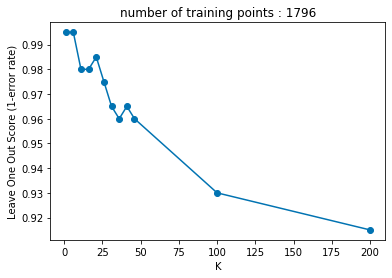

In [41]:
weights='uniform'
curve = LOOCurve(k_range = list(k),weights=weights)
LOOCurve.fit_curve(curve,digits.data, digits.target)
LOOCurve.plot(curve)

## Linear Discirmiant Analysis (LDA)
Bayes’Theorem for a random variable is the following: $  P(X = x \mid Y = y) = \frac{P(Y = y \mid X = x) P(X = x)}{P(Y = y)} $.

The posterior probabilities are defined as:

For Y = 1: $$ P(Y = 1 \mid X = x) = \frac{P(X = x \mid Y = 1) P(Y = 1)} {P(X = x)}$$
$$ P(Y = 1 \mid X = x) = \frac{f_+ \pi_+}{P(X = x)} $$
$$ P(Y = 1 \mid X = x) = \frac{f_+ \pi_+}{P(X = x \mid Y = 1 )P(Y = 1)+ P(X = x \mid Y = -1 )P(Y = -1)} $$



For Y = -1: 
$$ P(Y = -1 \mid X = x) = \frac{P(X = x \mid Y = -1) P(Y = -1)}{P(X = x)}$$
$$ P(Y = -1 \mid X = x) = \frac{f_(1 - \pi_+)}{P(X = x)} $$
$$ P(Y = 1 \mid X = x) = \frac{f_(1 -\pi_+)}{(f_+\pi_+ + f_-\pi_-)}$$

Log ratio:$$ log\left(\frac{P(Y = 1 \mid X = x)}{Y = -1 \mid X = x}\right) = log\left(\frac{f_+\pi_+}{f_-(1-\pi_+)}\right)$$
$$ \frac{f_+}{f_-} =  exp\left\{\frac{1}{2}\left[(x-\mu_-)^T \Sigma^{-1} (x-\mu_-) - \left((x-\mu_+)^T \Sigma^{-1} (x-\mu_+)\right)  \right]\right\}$$
$$ \frac{f_+}{f_-} =  exp\left\{-x^T\Sigma^{-1}\mu_-  + x^T\Sigma^{-1}\mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$$
$$ \frac{f_+}{f_-} =  exp\left\{x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ \right\}$$
$$ log\left(\frac{P(Y = 1 \mid X = x)}{Y = -1 \mid X = x}\right) = x^T\Sigma^{-1}(\mu_+ - \mu_-) + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+  + log\left(\frac{\pi_+}{(1-\pi_+)}\right)$$

If $Y$ = 1, then :
$$P(Y = 1 \mid X = x)> P(Y = -1 \mid X = x)$$
$$log(\frac{P(Y = 1 \mid X = x)}{P(Y = -1 \mid X = x})> 1$$

$$ x^{T} \Sigma^{-1}(\mu{+}-\mu{-}) -\frac{1}{2} \mu^{T}{+}\Sigma^{-1}\mu{+} \frac{1}{2} \mu^{T}{-}\Sigma^{-1}\mu{-} - \log(1-\frac{m}{n}) + \log(\frac{m}{n}) > 0$$

$$x^{T} \Sigma^{-1}(\mu{+}-\mu{-}) >\frac{1}{2} \mu^{T}{+}\Sigma^{-1}\mu{+}
\frac{1}{2} \mu^{T}{-}\Sigma^{-1}\mu{-} + \log(1-\frac{m}{n}) - \log(\frac{m}{n}) $$

Same logic for $Y$ = -1

###  LDAClassifier from scratch

In [ ]:
class LDAClassifier():
    def __init__(self):
        pass
    
    def fit(self,X,y):
        self.X=X
        self.y=y
        return self

    def predict(self, x):
        
        def sigma_pos(X, y, mu_pos):
            sigma_pos = sum([np.dot((x-mu_pos).reshape((-1,1)),(x-mu_pos).reshape((-1,1)).T) for x, y in zip(X, y) if y == 1])/(np.count_nonzero(y == 1)-1)
            return sigma_pos
        
        def sigma_pos(X, y, mu_neg):
            sigma_pos = sum([np.dot((x-mu_neg).reshape((-1,1)),(x-mu_neg).reshape((-1,1)).T) for x, y in zip(X, y) if y == -1])/(np.count_nonzero(y == 1)-1)
            return sigma_pos
        
        def sigma(sigma_pos, sigma_neg):
            sigma = ((np.count_nonzero(y == 1)-1)*sigma_pos+(np.count_nonzero(y == -1)-1)*sigma_neg)/(np.count_nonzero(y)-2)
            return sigma
        
        def foo(x,y):
            try:
                return x/y
            except ZeroDivisionError:
                return 0
    
        self.pi_pos=foo(np.count_nonzero(self.y == 1),self.y.size)
        
        self.mu_pos=foo(sum([self.X for self.X,self.y in zip(self.X,self.y) if self.y ==1]),np.count_nonzero(self.y == 1))       
        self.mu_neg=foo(sum([self.X for self.X,self.y in zip(self.X,self.y) if self.y ==-1]),np.count_nonzero(self.y ==-1))       
        
        
        self.sigma_pos = get_sigma_pos(self.X, self.y, self.mu_pos) 
        self.sigma_neg = get_sigma_neg(self.X, self.y, self.mu_neg) 
        self.sigma = get_sigma(self.sigma_pos, self.sigma_neg)
        
        clf=[]
        for i in x:
            if np.dot(np.dot(x.reshape((-1,1)).T, np.linalg.inv(sigma)), (mu_pos - mu_neg).reshape((-1,1))) > 0.5 * np.dot(np.dot(mu_pos.reshape((-1,1)).T, np.linalg.inv(sigma)), mu_pos.reshape((-1,1))) -0.5 * np.dot(np.dot(mu_neg.reshape((-1,1)).T, np.linalg.inv(sigma)), mu_neg.reshape((-1,1)))+ np.log(1 -pi_pos)- np.log(pi_pos):
                clf.append(1)
            else:
                clf.append(-1)
        
        return clf

In [42]:
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.1, 0.1]
sigma2 = [0.1, 0.1]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

In [ ]:
test= LDAClassifier()

test.fit(Xtrain,Ytrain)
test.predict(Xtest)
         
def f1(x):
    return test.predict(x)

plt.title("LDA from scratch")
frontiere_new(f1,Xtest,Ytest)
erreur1 = 1-test.score(Xtest,Ytest)
print("Error LDAClassifier: " + str(round(erreur1,3)))

### LDAClassifier for dataset #3

In [ ]:
n1=100
n2=100
sigma1=1
sigma2=2

X3, y3 =rand_clown(n1, n2, sigma1, sigma2)
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X3[:50], y3[:50] , test_size=0.8)

test= LDAClassifier()

test.fit(Xtrain,Ytrain)
test.predict(Xtest)


plt.title("LDA from scratch")
frontiere_new(f1,Xtest,Ytest)
erreur1 = 1-test.score(Xtest,Ytest)
print("Error LDAClassifier: " + str(round(erreur1,3)))

### LDA classifier from sklearn
The considered sample contains (x1, y1), . . . ,(xn, yn) and $ \Sigma  {1} $ {yi = +1} = m


We will choose a small sample for training and a large sample for the validation.

Error with sklearn classifier : 0.0


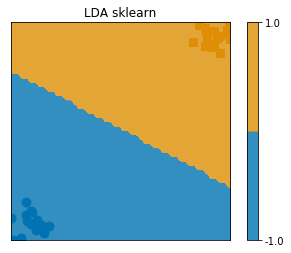

In [43]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X1[:50], y1[:50] , test_size=0.8) #small sample for training

lda=LinearDiscriminantAnalysis()
lda.fit(Xtrain,Ytrain)

lda.predict(Xtest)

def f2(x):
    return lda.predict(x.reshape(1, -1))

plt.title("LDA sklearn")
frontiere_new(f2,Xtest,Ytest)
erreur2 = 1-lda.score(Xtest,Ytest)
print("Error with sklearn classifier : " + str(round(erreur2,3)))

### Logistic regression with rand_bi_gauss

In [44]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X1[:50], y1[:50] , test_size=0.8) #small sample for training

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(Xtrain,Ytrain)
                                                        
clf.predict(Xtest)
erreur3 = 1-lda.score(Xtest,Ytest)
print("Error by applying a logistic regression: " + str(round(erreur3,3)))

Error by applying a logistic regression: 0.0


### Logistic regression: Desiquilibrated data (rand_bi_gauss)

In [45]:
n1 = 50
n2 = 5
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.1, 0.1]
sigma2 = [0.1, 0.1]
Xd, yd = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)
Xtrain,Xtest,Ytrain,Ytest = train_test_split(Xd[:50], yd[:50] , test_size=0.8)

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(Xtrain,Ytrain)                                                       
pred_d=clf.predict(Xtest)
errd = 1-lda.score(Xtest,Ytest)
accuracy_d = accuracy_score(Ytest, pred_d)
print("Error by applying a logistic regression: " + str(round(errd,3)))
print("Accuracy for desiquilibrated data : ",accuracy_d)


Error by applying a logistic regression: 0.0
Accuracy for desiquilibrated data :  1.0


### Coef_ et intercept_
- coef_ is the coefficient of the features in the decision function.
- intercept_ is the intercept (bias) added to the decision function.


### Visualisation of the decision border

coef_ :  [[0.52 0.57]]
intercept_ :  [0.65]


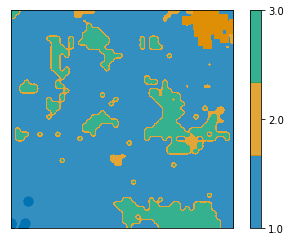

In [46]:
print('coef_ : ', clf.coef_)
print('intercept_ : ', clf.intercept_)
plt.figure()
plot_2d(Xd, yd)
frontiere_new(f, Xd, yd)

### Logistic regression for digits dataset

In [47]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.5, random_state=1)
lrd = linear_model.LogisticRegression()
model = lrd.fit(X_train, y_train)
pred_dig = model.predict(X_test)
accuracy = accuracy_score(y_test, pred_dig)
print("Accuracy of logistic regression : ", accuracy)

Accuracy of logistic regression :  0.946607341490545


/home/sonia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sonia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
